In [1]:
using Pkg 
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets,LaTeXStrings   
using Zygote, Optim, ForwardDiff
using KernelFunctions, MAT, LoopVectorization
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix 
import ReactiveMP: approximate_meancov, approximate_kernel_expectation, WishartFast, logdet
import RxInfer: PointMassFormConstraint,call_boundaries, call_starting_point

In [3]:
include("MultiSGPnode.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

In [4]:
function predict_gp(X_test, Xu, Yu, var_Yu,C, kernel)
    Kuu = kron(C,kernelmatrix(kernel,Xu))
    K_test_u =kron(C,kernelmatrix(kernel,X_test,Xu))
    Ktest =kron(C,kernelmatrix(kernel,X_test))

    μ = K_test_u * Yu 
    Σ = Ktest - K_test_u * inv(Kuu + Diagonal(var_Yu)) * K_test_u'
    return μ, Σ
end

function  PredictState(prev_state, qv, qw ,qθ, meta)
    return @call_rule MultiSGP(:out, Marginalisation) (q_in = prev_state, q_v = qv, q_w = qw,q_θ = qθ, meta = meta)
end
function UpdateState(prior_prediction, observation)
    likelihood_update = @call_rule MvNormalMeanCovariance(:μ, Marginalisation) (m_out = PointMass(observation), m_Σ = PointMass(P))
    x = ReactiveMP.prod(GenericProd(), prior_prediction, likelihood_update)
    return x
end

## Prediction
function predict_UT(f, qx,qw, meta)
    qz = ReactiveMP.approximate(meta, f, (qx,))
    prediction_x = @call_rule MvNormalMeanPrecision(:out, Marginalisation) (q_μ = qz, q_Λ = qw)
    return prediction_x
end


predict_UT (generic function with 1 method)

In [5]:
N = 700
max_time = 7
Δt = max_time / (N-1)

function transition_function(x_prev)
    x_1 = x_prev[1] + x_prev[2] * Δt 
    x_2 = x_prev[2] - 9.81 * sin(x_prev[1]) * Δt
    return [x_1, x_2]
end

function generate_data(n,x_init, Q, P;rng = MersenneTwister(124))
    x_prev = x_init  #initial angle and angular velocity
    x = Vector{Vector{Float64}}(undef, n)
    y = Vector{Vector{Float64}}(undef, n)
    for i in 1:n
        x[i] = transition_function(x_prev) + rand(rng, MvNormal(zeros(2),Q))
        y[i] = x[i] + rand(rng, MvNormal(zeros(2),P))
        x_prev = x[i]
    end
    return x, y 
end

generate_data (generic function with 1 method)

In [6]:
qc = 0.01
Q = [qc*Δt^3/3 qc*Δt^2/2;qc*Δt^2/2 qc*Δt]

P = 0.1*diageye(2) 
H = [1,0]
x_init = [1.5, 0.]

x_state, y_observation = generate_data(N,x_init, Q,P);
time_interval = collect(0:Δt:max_time)
;

In [7]:
n_train = 300
true_state_train = x_state[1:n_train]
y_train = y_observation[1:n_train]
true_state_test = x_state[1+n_train:end]
y_test = y_observation[1+n_train:end];

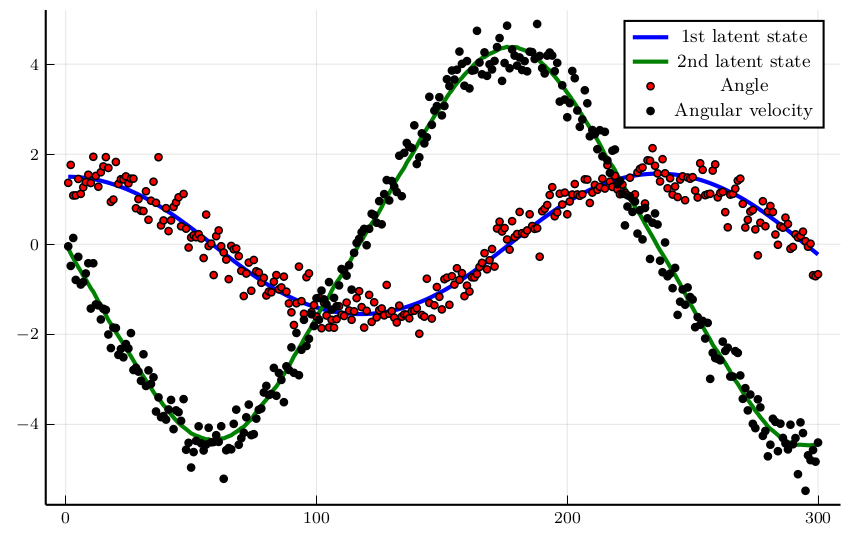

In [48]:
plot(getindex.(true_state_train,1), lw=2,label="1st latent state",color=:blue,
fontfamily="monospace",legendfontsize=9)
plot!(getindex.(true_state_train,2), lw=2, label="2nd latent state",color=:green)
scatter!(getindex.(y_train,1), markersize = 2.3, label="Angle", legend=:topright,color=:red)
scatter!(getindex.(y_train,2), markersize = 2.3, label="Angular velocity",color=:black)
# scatter!(time_interval, getindex.(y_observation,2), size=[800,300], markersize = 1.8, label="observation")

In [49]:
savefig("texfiles/pendulum_observation.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/pendulum_observation.svg"

In [8]:

Xu_2_neg1 = reverse(collect(range(-4,0;length=12)));
Xu_2_neg2 = reverse(Xu_2_neg1) .+ 1e-5
Xu_2_pos1 = collect(range(1e-4,4;length=12));
Xu_2_pos2 = reverse(Xu_2_pos1)
Xu_2 = vcat(Xu_2_neg1,Xu_2_neg2,Xu_2_pos1,Xu_2_pos2)

Xu_1 = collect(range(-2,2;length=Int(length(Xu_2)/2)));
Xu_1 = vcat(reverse(Xu_1), Xu_1 .+ 1e-5);

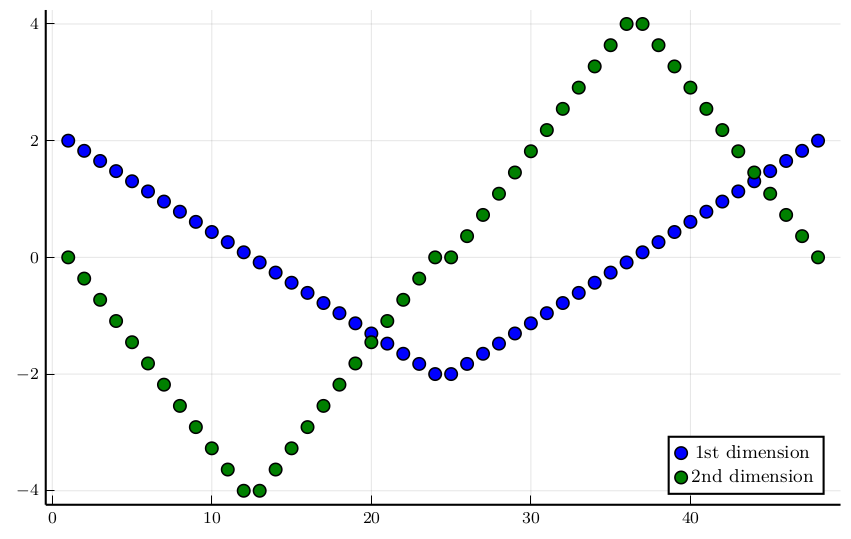

In [50]:
scatter(Xu_1,label="1st dimension", legend= :bottomright,color=:blue,
fontfamily="monospace",legendfontsize=9)
scatter!(Xu_2,label="2nd dimension",color=:green)

In [51]:
savefig("texfiles/pendulum_inducingpoint.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/pendulum_inducingpoint.svg"

In [9]:
## 2-D data, fully observed
@model function pendulum_GP(y,dim_v,P,θ)
    v ~ MvNormalMeanCovariance(zeros(dim_v), 50*diageye(dim_v))
    W ~ Wishart(1e2,diageye(2))
    x_prev ~ MvNormalMeanCovariance([1.6,0], 0.1*diageye(2))

    for i=1:length(y)
        x[i] ~ MultiSGP(x_prev,v,W,θ)
        y[i] ~ MvNormalMeanCovariance(x[i], P)
        x_prev = x[i]
    end
end

In [10]:
Xu = [[Xu_1[i],Xu_2[i]] for i=1:length(Xu_1)]
kernel_gp(θ) = θ[1] * with_lengthscale(Matern52Kernel(), θ[2])
meanfunc = (x) -> 0.0

C = diageye(2)  #coregionalization matrix 
dim_v = size(C,1) * length(Xu)
;

In [11]:
@meta function gpssm_meta(method,Xu,C,kernel,cache)
    MultiSGP() -> MultiSGPMeta(method,Xu,C,kernel,cache)
end

gp_constraint = @constraints begin
    q(x,x_prev,v,W) = q(x)q(x_prev)q(v)q(W)
    q(x) = q(x[begin])..q(x[end])
end

gp_initialization = @initialization begin
    q(v) = MvNormalMeanCovariance(zeros(dim_v),50*diageye(dim_v))
    q(x) = MvNormalMeanCovariance(zeros(2), 50diageye(2))
    q(W) = Wishart(1e2,diageye(2))
end
;

In [12]:
function my_free_energy(θ)
    
    infer_result_gp = infer(
        model = pendulum_GP(dim_v = dim_v,P = P, θ = θ,),
        iterations = 10,
        data = (y = y_train,),
        initialization = gp_initialization,
        meta = gpssm_meta(srcubature(),Xu, C,kernel_gp,GPCache()),
        constraints = gp_constraint,
        free_energy = true,
    ) 
    
    return infer_result_gp.free_energy[end]
end

function learn_params(θ,iteration)
    lower = [0.1,0.1]
    upper = [10,10]
    res = optimize((x) -> my_free_energy(x),lower,upper,θ,Fminbox(NelderMead()),Optim.Options(iterations = iteration))
    return res.minimizer
end

learn_params (generic function with 1 method)

In [24]:
θ_init = [1.,1.]
θ_optimal = learn_params(θ_init,5)

2-element Vector{Float64}:
 0.26453857421875016
 3.2402221679687493

In [17]:
niter = 30;

infer_result_gp = infer(
    model = pendulum_GP(dim_v = dim_v,P = P, θ = θ_optimal,),
    iterations = niter,
    data = (y = y_train,),
    initialization = gp_initialization,
    meta = gpssm_meta(srcubature(),Xu,C,kernel_gp,GPCache()),
    constraints = gp_constraint,
    returnvars = (x = KeepLast(), v = KeepLast(), W = KeepLast(),),
    free_energy = true,
    showprogress = true
) 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


Inference results:
  Posteriors       | available for (v, W, x)
  Free Energy:     | Real[2606.52, 1872.91, 791.472, 589.708, 519.621, 485.454, 465.888, 453.655, 445.625, 440.197  …  427.371, 427.257, 427.173, 427.117, 427.068, 427.03, 427.018, 426.993, 426.978, 426.976]


In [18]:
qv_gp = infer_result_gp.posteriors[:v]
qx_gp = infer_result_gp.posteriors[:x];
qw_gp = infer_result_gp.posteriors[:W];

## Unscented Transform (known function)

In [29]:
@model function VMPsmoothing(y,P)
    W ~ Wishart(1e2, diageye(2))
    x_prev ~ MvNormalMeanCovariance([1.6,0], 0.1*diageye(2))

    for i=1:length(y)
        x[i] ~ MvNormalMeanPrecision(transition_function(x_prev), W)
        y[i] ~ MvNormalMeanCovariance(x[i], P)
        x_prev = x[i]
    end
end

In [30]:
meta_VMPsmoothing = @meta begin
    transition_function() -> UT()
end

ut_constraint = @constraints begin
    q(x,x_prev,W) = q(x)q(x_prev)q(W)
    q(x) = q(x[begin])..q(x[end])
end

ut_initialization = @initialization begin
    q(W) = Wishart(1e2,diageye(2))
    q(x) = MvNormalMeanCovariance(zeros(2), 50*diageye(2))
end

infer_result_VMPsmoothing = infer(
    model = VMPsmoothing(P=P),
    data = (y = y_train,),
    meta = meta_VMPsmoothing,
    iterations = niter,
    constraints = ut_constraint,
    initialization = ut_initialization,
    returnvars = (x = KeepLast(), W = KeepLast(),),
    options = (limit_stack_depth=100,),
    free_energy = true
) 

qx_UT = infer_result_VMPsmoothing.posteriors[:x];
qw_UT = infer_result_VMPsmoothing.posteriors[:W]
;

## Result comparison 

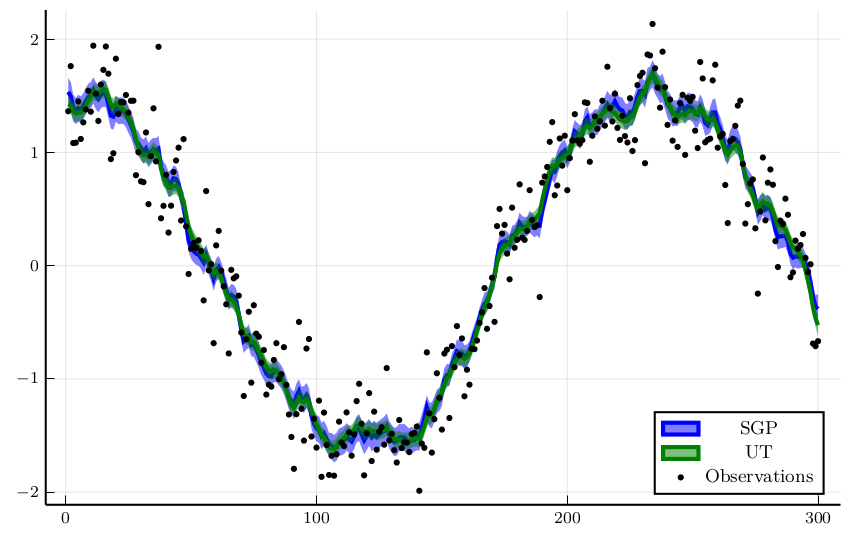

In [52]:
plot(getindex.(mean.(qx_gp),1),ribbon = sqrt.(getindex.(var.(qx_gp),1)),label="SGP",
     lw = 2,
     color=:blue)
plot!(getindex.(mean.(qx_UT),1),ribbon = sqrt.(getindex.(var.(qx_UT),1)),
    label="UT", lw = 2, legend=:bottomright,
    color=:green,
    fontfamily="monospace",legendfontsize=9)

scatter!(getindex.(y_train,1), markersize=1.5, label="Observations",color=:black)

In [53]:
savefig("texfiles/pendulum_1st_state.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/pendulum_1st_state.svg"

In [60]:
function rmse_score(y_predict, y_true)
    return sqrt(mean((y_predict - y_true).^2))
end
rmse_UT_1st_state = rmse_score(getindex.(true_state_train,1), getindex.(mean.(qx_UT),1))
rmse_GPnode_1st_state = rmse_score(getindex.(true_state_train,1), getindex.(mean.(qx_gp),1))
println("The rmse of SGP node: $rmse_GPnode_1st_state")
println("The rmse of UT: $rmse_UT_1st_state")

The rmse of SGP node: 0.1109496323205158
The rmse of UT: 0.11116435292997408


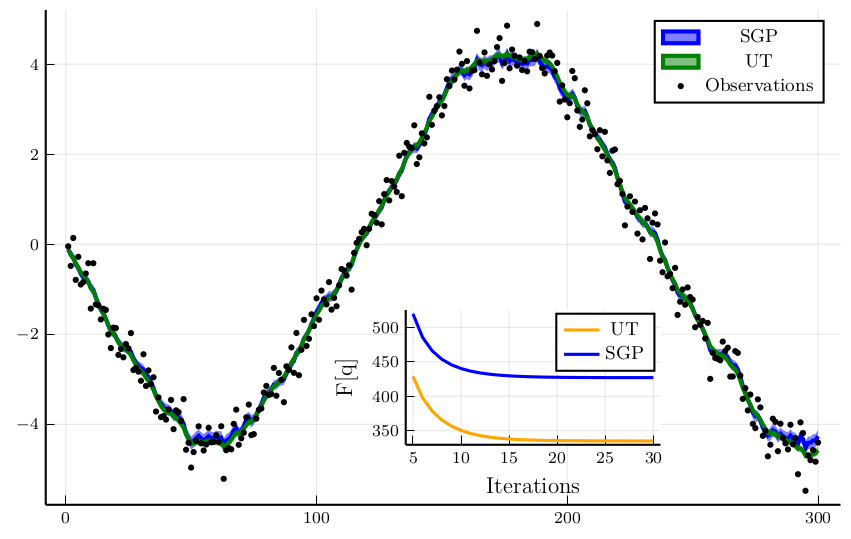

In [58]:
plot(getindex.(mean.(qx_gp),2),ribbon = sqrt.(getindex.(var.(qx_gp),2)),label="SGP", 
        lw = 2, color=:blue,
        fontfamily="monospace",legendfontsize=9)
plot!(getindex.(mean.(qx_UT),2),ribbon = sqrt.(getindex.(var.(qx_UT),2)),label="UT", 
                lw = 2, legend=:topright, color=:green)
scatter!(getindex.(y_train,2), markersize=1.5, label="Observations", color=:black)

plot!([collect(5:30),collect(5:30)],
    [infer_result_VMPsmoothing.free_energy[5:30], infer_result_gp.free_energy[5:30]], 
    label=["UT" "SGP"],
    color=[:orange :blue],
    lw= [1.5 1.5],
    legend=:topright,
    legend_font_pointsize=6,
    inset = (1, bbox(0.4, 0.1, 0.4, 0.4, :bottom, :left)),
    xlabel="Iterations",
    ylabel="F[q]",
    subplot = 2,
    fontfamily="monospace",legendfontsize=9)

In [59]:
savefig("texfiles/pendulum_2nd_state.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/pendulum_2nd_state.svg"

In [61]:
rmse_UT_2st_state = rmse_score(getindex.(true_state_train,2), getindex.(mean.(qx_UT),2))
rmse_GPnode_2st_state = rmse_score(getindex.(true_state_train,2), getindex.(mean.(qx_gp),2))
println("The rmse of SGP node: $rmse_GPnode_2st_state")
println("The rmse of UT: $rmse_UT_2st_state")

The rmse of SGP node: 0.12299400863324611
The rmse of UT: 0.10188981659507003


## One- step-ahead prediction

In [19]:
prev_state = qx_gp[end]
predicted_state = []
for i=1:length(y_test)
    prediction = PredictState(prev_state,qv_gp,qw_gp,PointMass(θ_optimal), MultiSGPMeta(srcubature(),Xu,C,kernel_gp,GPCache()))
    push!(predicted_state,prediction)
    prev_state = UpdateState(prediction, y_test[i])
end

UT_predict_future = []
UT_var_predict_future = []
UT_prev_state = qx_UT[end]
for i=1:length(y_test)
    prediction = predict_UT(transition_function, UT_prev_state, qw_UT, UT())
    append!(UT_predict_future,mean(prediction)[1])
    append!(UT_var_predict_future,var(prediction)[1]) 
    UT_prev_state = UpdateState(prediction, y_test[i])
end
;

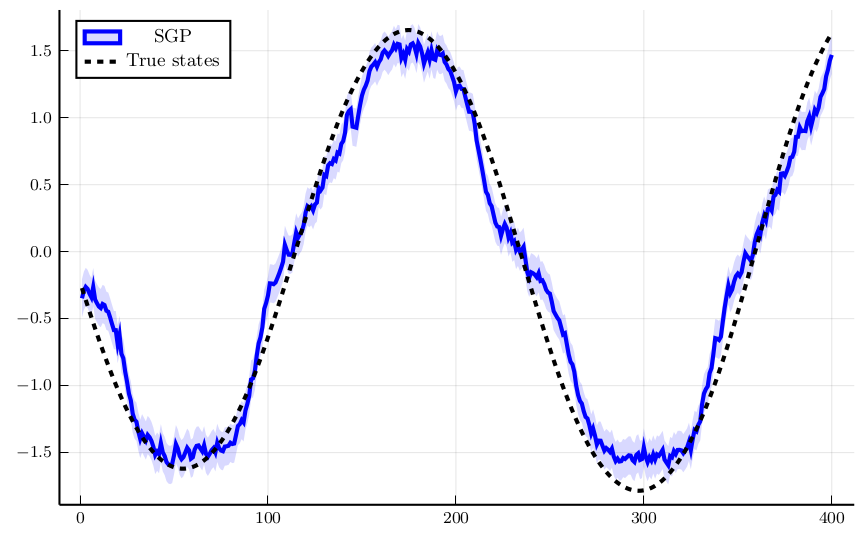

In [20]:
plot(getindex.(mean.(predicted_state),1),ribbon = sqrt.(getindex.(var.(predicted_state),1)) , legend=:topleft,
        label="SGP",lw=2, color=:blue,
        fontfamily="monospace",legendfontsize=9, fillalpha=0.15)

# plot!(UT_predict_future,ribbon=sqrt.(UT_var_predict_future),
#     label="UT",lw=2, legend=:topleft, color=:green, fillalpha=0.15)

plot!(getindex.(true_state_test,1),label="True states", ls=:dash,lw=2, color=:black)
# xlabel!("t")

In [21]:
savefig("texfiles/pendulum_1stepprediction.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/pendulum_1stepprediction.svg"

In [64]:
rmse_UT_prediction = rmse_score(getindex.(true_state_test,1), UT_predict_future)
rmse_GPnode_prediction = rmse_score(getindex.(true_state_test,1), getindex.(mean.(predicted_state),1))
println("The rmse of SGP node: $rmse_GPnode_prediction")
println("The rmse of UT: $rmse_UT_prediction")

The rmse of SGP node: 0.20145462193059183
The rmse of UT: 0.07842974344091093


less_noise (generic function with 1 method)

In [30]:
# function less_noise(var_y)
#     #     P_local = var_y * diageye(2)
#     #     x_state_local, y_observation_local = generate_data(N,x_init, Q,P_local);
#     #     y_train_local = y_observation_local[1:n_train]
    
#     #     function my_free_energy_local(θ)
        
#     #         infer_result_gp = infer(
#     #             model = pendulum_GP(dim_v = dim_v,P = P_local, θ = θ,),
#     #             iterations = 10,
#     #             data = (y = y_train_local,),
#     #             initialization = gp_initialization,
#     #             meta = gpssm_meta(srcubature(),Xu, C,kernel_gp,GPCache()),
#     #             constraints = gp_constraint,
#     #             free_energy = true,
#     #         ) 
            
#     #         return infer_result_gp.free_energy[end]
#     #     end
    
#     #     function learn_params_local(θ,iteration)
#     #         lower = [0.1,0.1]
#     #         upper = [10,10]
#     #         res = optimize((x) -> my_free_energy_local(x),lower,upper,θ,Fminbox(NelderMead()),Optim.Options(iterations = iteration))
#     #         return res.minimizer
#     #     end
    
#     #     θ_init = [1.,1.]
#     #     θ_optimal_local = learn_params_local(θ_init,5)
    
#     #     infer_result_gp_local = infer(
#     #     model = pendulum_GP(dim_v = dim_v,P = P_local, θ = θ_optimal_local,),
#     #     iterations = 30,
#     #     data = (y = y_train_local,),
#     #     initialization = gp_initialization,
#     #     meta = gpssm_meta(srcubature(),Xu,C,kernel_gp,GPCache()),
#     #     constraints = gp_constraint,
#     #     returnvars = (x = KeepLast(), v = KeepLast(), W = KeepLast(),),
#     #     free_energy = false,
#     #     showprogress = true
#     #     ) 
#     #     qv_gp_local = infer_result_gp_local.posteriors[:v]
#     #     qx_gp_local = infer_result_gp_local.posteriors[:x];
#     #     qw_gp_local = infer_result_gp_local.posteriors[:W];
#     #     return qv_gp_local, qx_gp_local, qw_gp_local, θ_optimal_local
#     # end
#     qv_gp_001, qx_gp_001, qw_gp_001, θ_optimal_001 = less_noise(0.01);
# qv_gp_0001, qx_gp_0001, qw_gp_0001, θ_optimal_0001 = less_noise(0.001);
# prev_state_001 = qx_gp_001[end]
# _, y_observation_001 = generate_data(N,x_init, Q,0.01);
# y_test_001 = y_observation_001[1+n_train:end]
# predicted_state_001 = []
# for i=1:length(y_test)
#     prediction = PredictState(prev_state_001,qv_gp_001,qw_gp_001,PointMass(θ_optimal_001), MultiSGPMeta(srcubature(),Xu,C,kernel_gp,GPCache()))
#     push!(predicted_state_001,prediction)
#     prev_state_001 = UpdateState(prediction, y_test_001[i])
# end

# prev_state_0001 = qx_gp_0001[end]
# _, y_observation_0001 = generate_data(N,x_init, Q,0.001);
# y_test_0001 = y_observation_0001[1+n_train:end]
# predicted_state_0001 = []
# for i=1:length(y_test)
#     prediction = PredictState(prev_state_0001,qv_gp_0001,qw_gp_0001,PointMass(θ_optimal_0001), MultiSGPMeta(srcubature(),Xu,C,kernel_gp,GPCache()))
#     push!(predicted_state_0001,prediction)
#     prev_state_0001 = UpdateState(prediction, y_test_0001[i])
# end
# plot(getindex.(mean.(predicted_state),1),ribbon = sqrt.(getindex.(var.(predicted_state),1)) , legend=:topleft,
#         label="SGP (var_y = 0.1)",lw=2, color=:red,
#         fontfamily="monospace",legendfontsize=9, fillalpha=0.15)

# plot!(getindex.(mean.(predicted_state_001),1),ribbon = sqrt.(getindex.(var.(predicted_state_001),1)) ,
#         label="SGP (var_y = 0.01)",lw=2, color=:green,
#         fontfamily="monospace",legendfontsize=9, fillalpha=0.15)

# plot!(getindex.(mean.(predicted_state_0001),1),ribbon = sqrt.(getindex.(var.(predicted_state_0001),1)) ,
#         label="SGP (var_y = 0.001)",lw=2, color=:blue,
#         fontfamily="monospace",legendfontsize=9, fillalpha=0.15)

# plot!(getindex.(true_state_test,1),label="True states", ls=:dash,lw=2, color=:black)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
